# Weekend Movie Trip

First, we will import the libraries we will use.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from IPython.display import display
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist

Now, lets import all the csv datasets into pandas dataframes

In [2]:
df_ratings = pd.read_csv('./data/ratings.csv')
df_movies  = pd.read_csv('./data/movies.csv')
df_links   = pd.read_csv('./data/links.csv')
df_tags    = pd.read_csv('./data/tags.csv')

In [3]:
display(df_ratings.head(3))
display(df_movies.head(3))
display(df_links.head(3))
display(df_tags.head(3))

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


## Feature Engineering

Initially for feature engineering, the genres column in the movies dataframe is going to be hard to run algorithms based on, so I will split up the genres.

I can accomplish this by splitting the genres based off of '|' and then encode them.

In [4]:
le = preprocessing.LabelEncoder()
genres_split = df_movies.genres.str.split('|', expand=True)
genre_columns = np.unique(pd.DataFrame(pd.DataFrame(genres_split.values).values.flatten()).dropna().values.ravel())
genre_columns = np.sort(genre_columns)[::-1]
for g in genre_columns:
    df_movies.insert(2, g,  [int(g in i) for i in df_movies.genres.str.split('|', expand=False)], True)
del df_movies['genres']

In [5]:
df_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


This is much better. Now, let's inspect how corellated the genres are with each other.

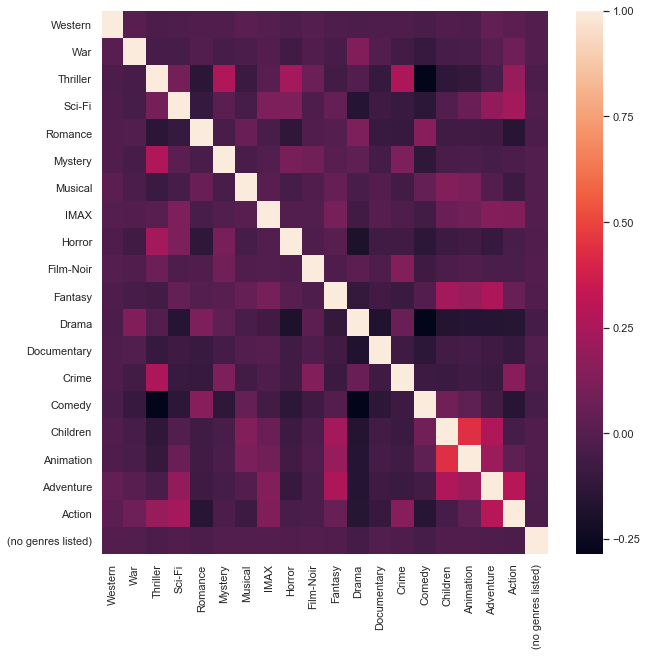

In [6]:
plt.figure(figsize = (10,10))
sns.heatmap(df_movies[genre_columns].corr())

Some of the stronger corellations here make sense. We can see some of the strongest correlations are Action/Adventure and Animation/Children.

Lets try getting the average rating for each of the movies.

In [7]:
def getAverageRating(movie_id):
    return df_ratings.loc[df_ratings['movieId'] == movie_id]['rating'].mean()
def getRatingCount(movie_id):
    return df_ratings.loc[df_ratings['movieId'] == movie_id]['rating'].count()

average_ratings = df_movies['movieId'].map(lambda x: getAverageRating(x))
rating_count = df_movies['movieId'].map(lambda x: getRatingCount(x))
df_movies['Rating'] = average_ratings
df_movies['Num_of_Ratings'] = rating_count

In [8]:
df_movies.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.920930,215
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.431818,110
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.259615,52
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.357143,7
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.071429,49


Now let's try sorting by the rating

In [9]:
df_movies.sort_values(by=['Rating', 'Num_of_Ratings'], ascending=False, inplace=True)
df_movies.head(4)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings
48,53,Lamerica (1994),0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,2
87,99,Heidi Fleiss: Hollywood Madam (1995),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,5.0,2
870,1151,Lesson Faust (1994),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,5.0,2
2597,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,5.0,2


We can see this gives 5.0 rated movies but that are only rated by 2 people and thus that gives movies that are overall much less quality than those with a slightly lower rating, but rated by much more people. To combat this, 

As we can see now, this is a much better sorting resulting in well known movie masterpeices floating to the top.

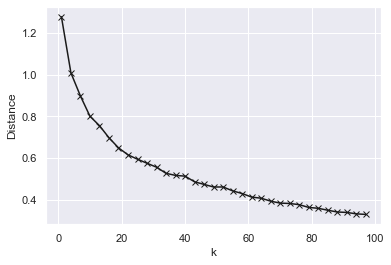

In [11]:
df_movies.dropna(inplace=True)
clusterFactors = df_movies.drop(columns=['Num_of_Ratings', 'Rating', 'title', 'movieId', 'MySort' ])
distances = []
K = range(1,100, 3)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(clusterFactors)
    kmeanModel.fit(clusterFactors)
    distances.append(sum(np.min(cdist(clusterFactors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clusterFactors.shape[0])

# Plot the elbow graph
plt.plot(K, distances, 'kx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.show()

From this we can see how the number of clusters affects distortion. Based on this, I'm going to select the number 20 as the number of clusters. This is about at the point of the "elbow" in the graph and makes sense as I can't name much more than 20 types of movies.

In [12]:
kmeans = KMeans(n_clusters=20).fit_predict(clusterFactors)
df_movies['Cluster'] = kmeans

In [13]:
df_movies.sort_values(by=['Cluster','MySort'], ascending=False, inplace=True)
df_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating,Num_of_Ratings,MySort,Cluster
512,595,Beauty and the Beast (1991),0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,3.770548,146,0.333774,19
815,1073,Willy Wonka & the Chocolate Factory (1971),0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,3.873950,119,0.287168,19
483,551,"Nightmare Before Christmas, The (1993)",0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,3.553763,93,0.188847,19
2028,2700,"South Park: Bigger, Longer and Uncut (1999)",0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,3.861842,76,0.182242,19
6405,50872,Ratatouille (2007),0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,3.868056,72,0.173205,19


In [14]:
def findSimilarMovie(movieTitle):
    cluster = df_movies.loc[df_movies['title'] == movieTitle]['Cluster'].values[0]
    cluster_movies = df_movies.loc[df_movies['Cluster'] == cluster]
    return pd.DataFrame(cluster_movies['title'].values).head(10)
findSimilarMovie('Toy Story (1995)')

,0
0,Toy Story (1995)
1,"Lion King, The (1994)"
2,Aladdin (1992)
3,Shrek (2001)
4,Finding Nemo (2003)
5,"Monsters, Inc. (2001)"
6,"Incredibles, The (2004)"
7,WALL·E (2008)
8,Up (2009)
9,Toy Story 2 (1999)


In [15]:
findSimilarMovie('I Am Legend (2007)')

,0
0,"Matrix, The (1999)"
1,Terminator 2: Judgment Day (1991)
2,Blade Runner (1982)
3,Men in Black (a.k.a. MIB) (1997)
4,"Terminator, The (1984)"
5,Ghostbusters (a.k.a. Ghost Busters) (1984)
6,Minority Report (2002)
7,V for Vendetta (2006)
8,Outbreak (1995)
9,28 Days Later (2002)


In [16]:
findSimilarMovie('Good Will Hunting (1997)')

,0
0,American Beauty (1999)
1,Good Will Hunting (1997)
2,Eternal Sunshine of the Spotless Mind (2004)
3,"Beautiful Mind, A (2001)"
4,Casablanca (1942)
5,Titanic (1997)
6,"Crouching Tiger, Hidden Dragon (Wo hu cang lon..."
7,Jerry Maguire (1996)
8,Edward Scissorhands (1990)
9,Slumdog Millionaire (2008)


As you can see, the recommendations are pretty good given the movies. The algorithm finds movies in a similar cluster of genres and serves the top rated movies in that cluster. Many of these recommendations make sense. 

In [17]:
from sklearn.cluster import AgglomerativeClustering
df_ac = df_movies.sort_values(by=['MySort'], ascending=False)
clusterFactors2 = df_ac.drop(columns=['Num_of_Ratings', 'Rating', 'title', 'movieId', 'MySort', 'Cluster'])
agglomerative_clustering = AgglomerativeClustering(n_clusters=20).fit_predict(clusterFactors)
df_ac['AgglomerativeClustering'] = agglomerative_clustering
df_ac.sort_values(by=['AgglomerativeClustering', 'MySort'], inplace=True, ascending=False)

In [18]:
def findSimilarMovieAC(movieTitle):
    cluster = df_ac.loc[df_ac['title'] == movieTitle]['AgglomerativeClustering'].values[0]
    cluster_movies = df_ac.loc[df_ac['AgglomerativeClustering'] == cluster]
    return pd.DataFrame(cluster_movies['title'].values).head(10)

In [19]:
findSimilarMovieAC('Toy Story (1995)')

,0
0,"Lord of the Rings: The Fellowship of the Ring,..."
1,Toy Story (1995)
2,"Lord of the Rings: The Return of the King, The..."
3,"Lord of the Rings: The Two Towers, The (2002)"
4,Apollo 13 (1995)
5,Back to the Future (1985)
6,"Lion King, The (1994)"
7,Shrek (2001)
8,Monty Python and the Holy Grail (1975)
9,Pirates of the Caribbean: The Curse of the Bla...


In [20]:
findSimilarMovieAC('I Am Legend (2007)')

,0
0,"Matrix, The (1999)"
1,Fight Club (1999)
2,Jurassic Park (1993)
3,"Dark Knight, The (2008)"
4,Gladiator (2000)
5,Independence Day (a.k.a. ID4) (1996)
6,Léon: The Professional (a.k.a. The Professiona...
7,Blade Runner (1982)
8,Mission: Impossible (1996)
9,"Terminator, The (1984)"


In [21]:
findSimilarMovieAC('Good Will Hunting (1997)')

,0
0,American Beauty (1999)
1,Good Will Hunting (1997)
2,"Beautiful Mind, A (2001)"
3,Casablanca (1942)
4,Titanic (1997)
5,"Crouching Tiger, Hidden Dragon (Wo hu cang lon..."
6,Jerry Maguire (1996)
7,Leaving Las Vegas (1995)
8,Sense and Sensibility (1995)
9,"Piano, The (1993)"


Personally, I prefer the recommendations of K-Means, but potentially this could be extended to recommend movies that show up highly in both algorithms taking the best of both worlds.